In [4]:
import gc
import os
import time
from pathlib import Path 
from typing import Literal, Tuple
from nptyping import NDArray
from IPython import display

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from keras.models import Model, Sequential
from keras.metrics import Mean, MeanAbsoluteError
from keras.metrics import Mean
from tqdm.keras import TqdmCallback

from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.definitions import *
from jetstream_hugo.jet_finding import *

from desom.som_layer import SOMLayer
from desom.autoencoder import conv2d_autoencoder
from desom.desom import Desom
from desom.kerasom import Kerasom
from desom.callbacks import *
from desom.utils import *

%load_ext autoreload
%autoreload 2

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
exp_s = Experiment(
    "ERA5",
    "plev",
    "s",
    "6H",
    (1940, 2022),
    "JJA",
    -80,
    30,
    20,
    80,
    [200, 250, 300],
    None,
    None,
    None,
    reduce_da=True,
)
da_s = exp_s.da

In [3]:
# da_T_cropped = preprocess(da_T.chunk('auto'), [2] * 5, ['pad', 'crop']).compute(n_workers=8, memory_limit='1GB')
# da_s_cropped = preprocess(da_s.chunk("auto"), [2] * 5, ["pad", "crop"]).compute(
#     n_workers=8, memory_limit="1GB"
# )

X = da_s.values
# Y = da_T.values
# Xmin, Xmax = X.min(), X.max()
# Ymin, Ymax = Y.min(), Y.max()

# strides = [2, 2, 2, 2]
# Xp = preprocess(rescale(X), strides, ["pad", "crop"])
# Yp = preprocess(rescale(Y), strides, ['pad', 'crop'])

# X_test_size = 2500
# X_train_size = Xp.shape[0] - X_test_size
# X_train, X_test = train_test_split(Xp, train_size=X_train_size, test_size=X_test_size)
# Y_test_size = 2500
# Y_train_size = Yp.shape[0] - Y_test_size
# Y_train, Y_test = train_test_split(Yp, train_size=Y_train_size, test_size=Y_test_size)

# DESOM

In [4]:
%load_ext tensorboard

In [9]:
encoder_filters = [32, 32, 64, 64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256]
strides = [1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2]
# encoder_filters = [32, 32, 64, 64, 128, 128]
# strides = [1, 2, 1, 2, 1, 2]
latent_dim = 20
filter_sizes = 3
epochs = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, mode="min"
)

som_callback = SOMCallback(epochs, start_sigma=2, speed=3)
now = pd.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir_im = "logs/image/" + now
logdir_sc = "logs/scalar/" + now
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)
plot_som_callback = PlotSOMCallback(
    da_s_cropped, file_writer=file_writer, cmap="twilight_shifted", transparify=2
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir_sc, histogram_freq=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "/storage/homefs/hb22g102/persistent-extremes-era5/results/models/desom/checkpoint{epoch:02d}",
    save_best_only=False,
)

callbacks = [
    early_stopping,
    som_callback,
    plot_som_callback,
    checkpoint,
    TqdmCallback(verbose=1),
    tensorboard_callback,
]

encoder_wind, decoder_wind, autoencoder_wind = conv2d_autoencoder(
    Xp.shape[1:],
    latent_dim,
    encoder_filters,
    filter_sizes,
    strides,
    batchnorm=True,
    last_act="relu",
)
som_layer = SOMLayer((6, 6), KSN=True, name="som")
norm = degcos(da_s_cropped.lat).values[None, :, None, None]
desom = Desom(
    encoder_wind, decoder_wind, som_layer, factors=[10, 1e-1, 1e-3], norm=norm
)

desom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

batch_size = 8

desom.fit(
    X_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test,),
    callbacks=callbacks,
    verbose=0,
)

/scratch/local/511634/ipykernel_2159/2839516220.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  now = pd.datetime.now().strftime("%Y%m%d-%H%M%S")


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [6]:
desom = tf.keras.saving.load_model(
    "/storage/homefs/hb22g102/persistent-extremes-era5/results/models/desom/checkpoint19"
)

## Diagnostic plots

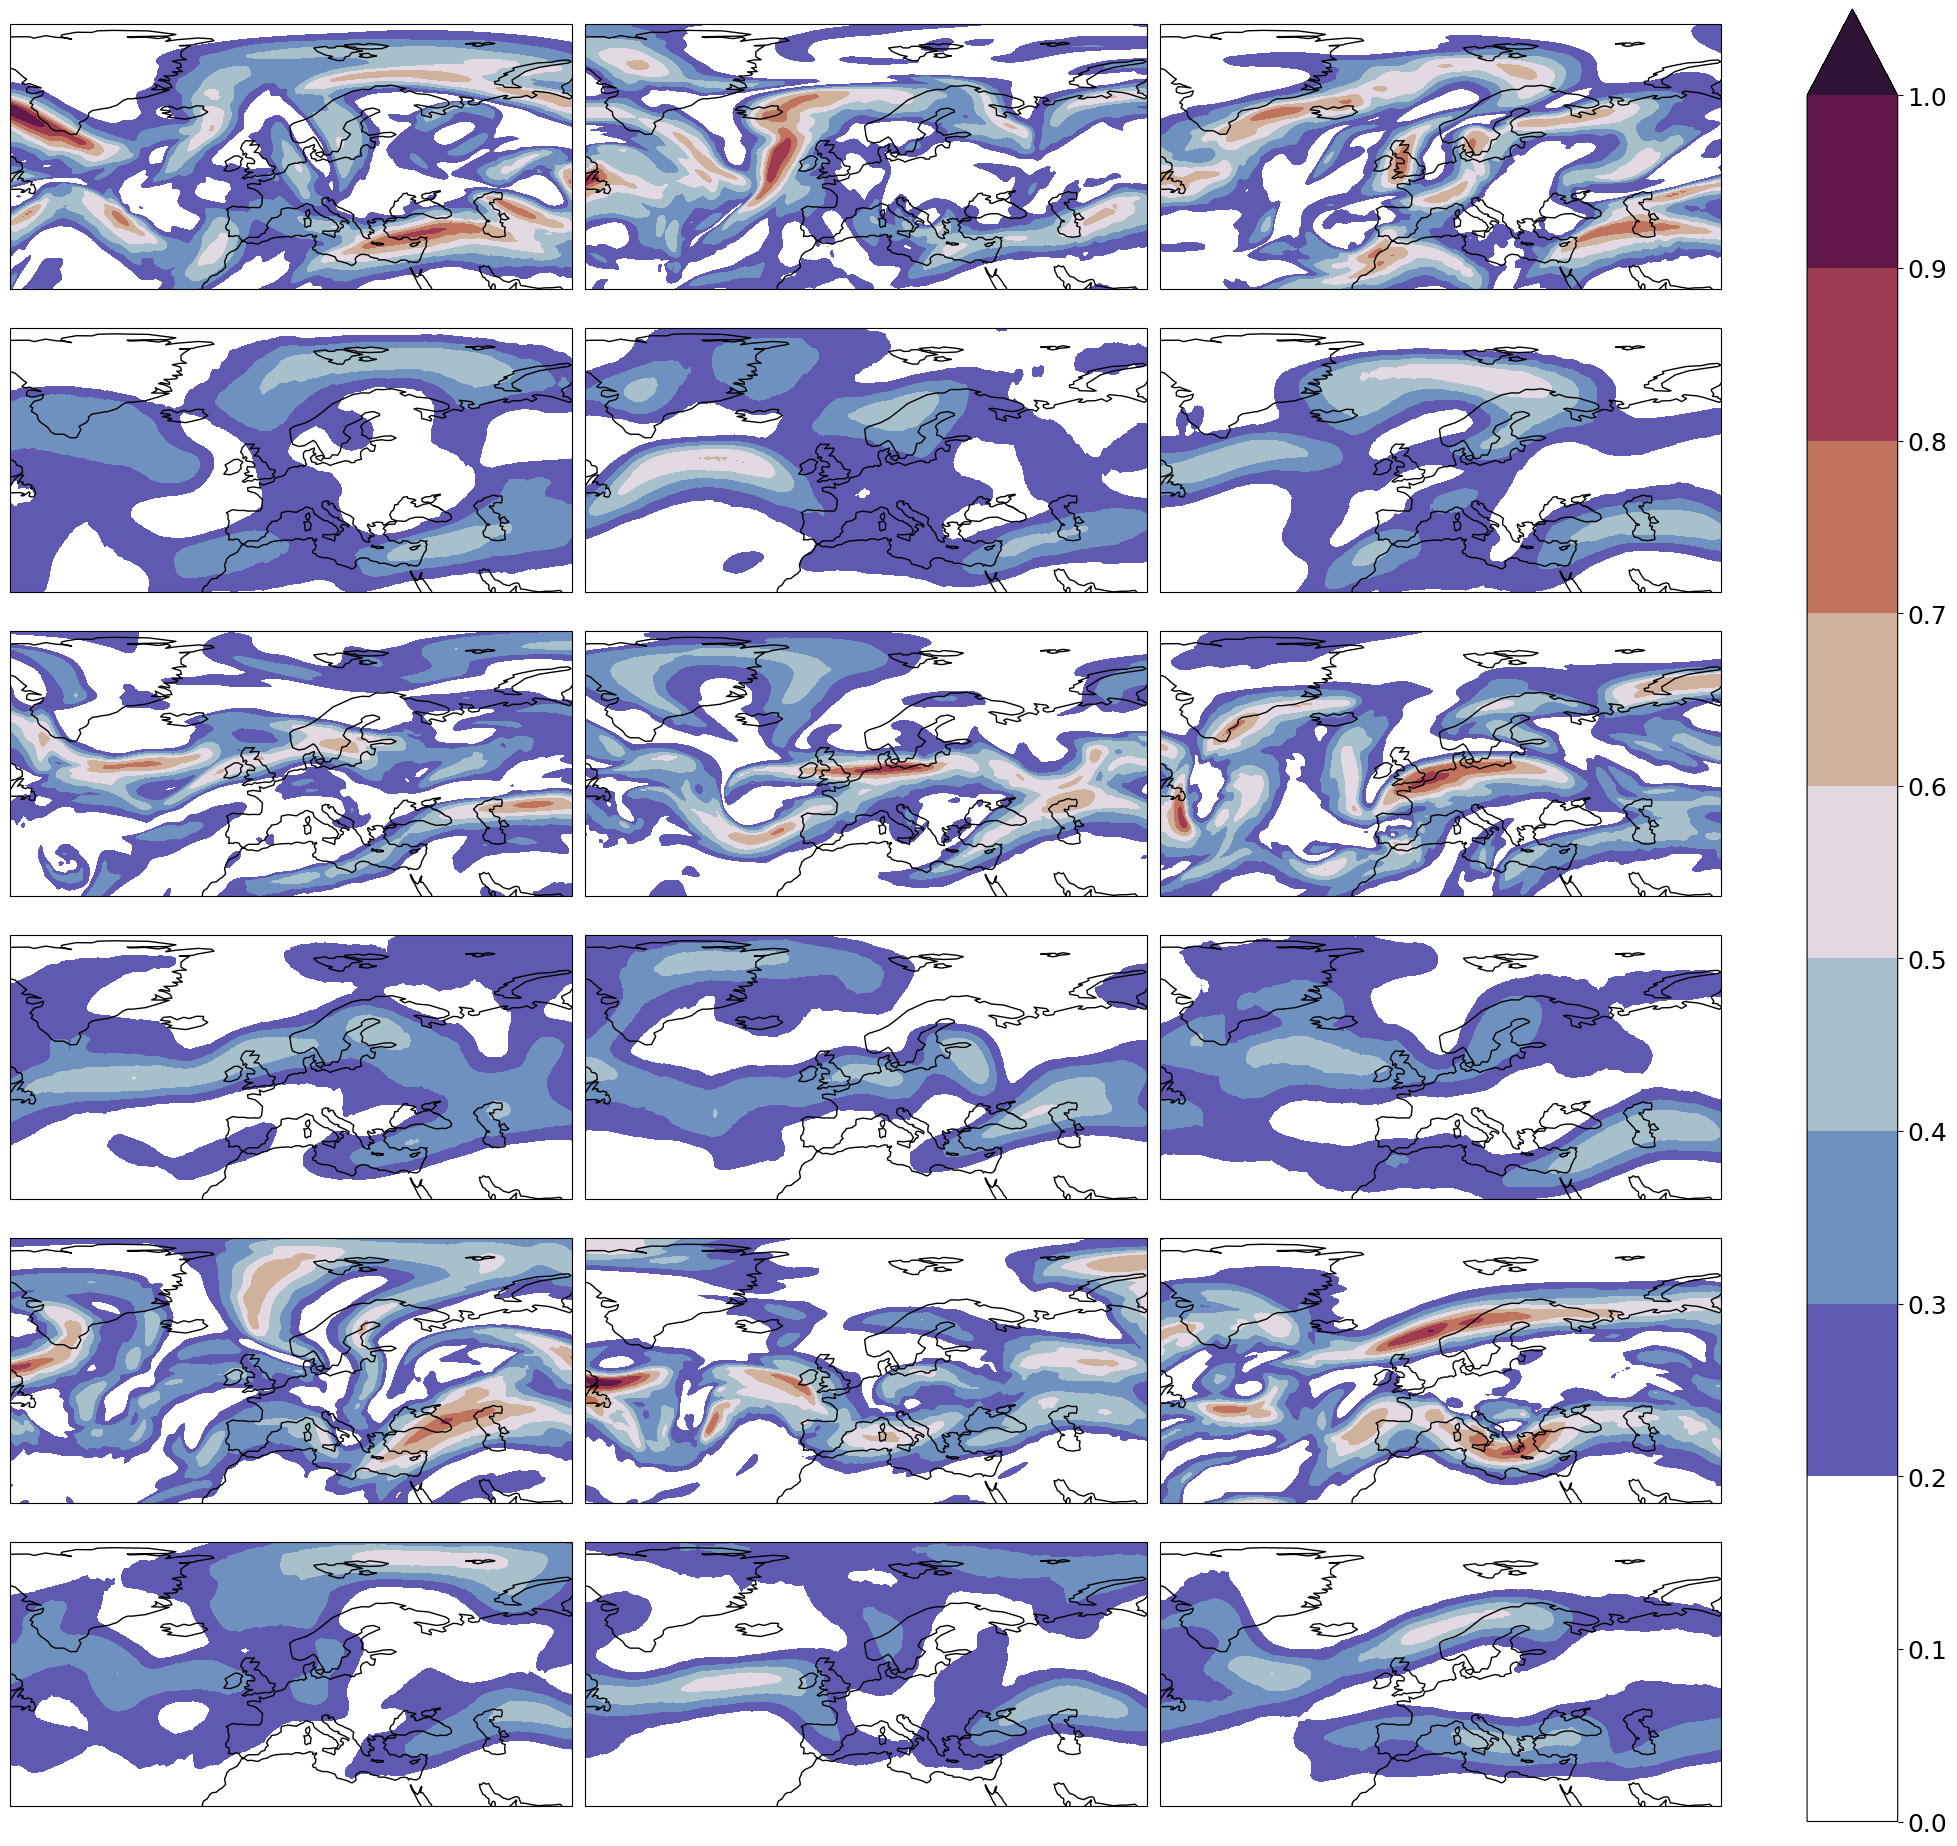

In [7]:
clu = showcase_ae(
    da_s_cropped,
    desom,
    9,
    cmap="twilight_shifted",
    transparify=2,
    nlevels=11,
    symmetrize=False,
    draw_cbar=True,
)

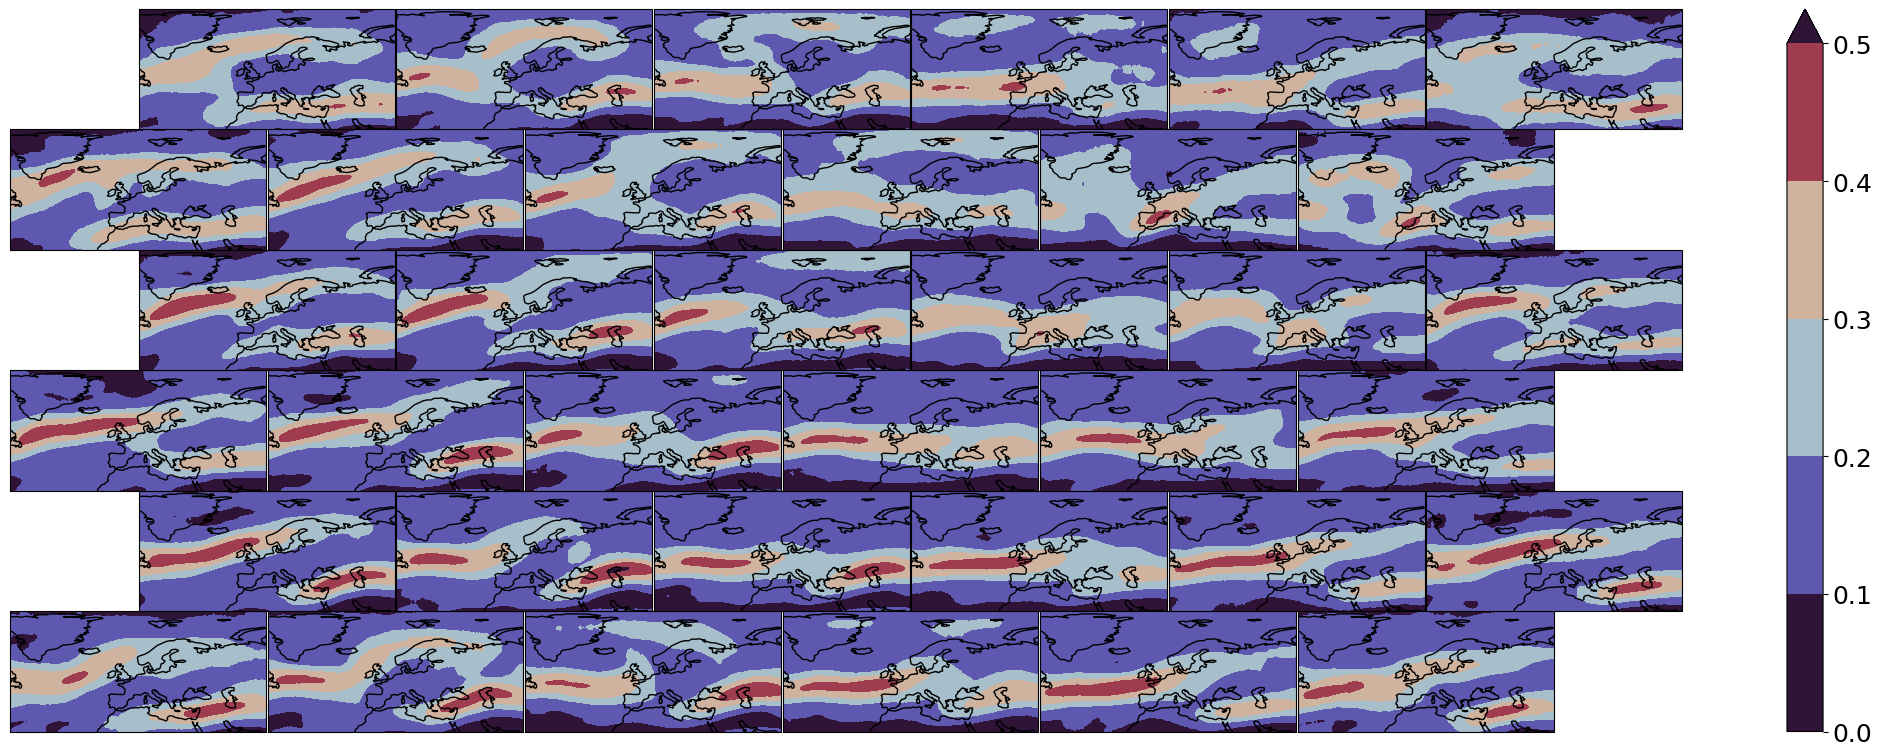

In [8]:
clu = showcase_desom(
    da_s_cropped[0], desom, cmap="twilight_shifted", transparify=0, draw_cbar=True
)

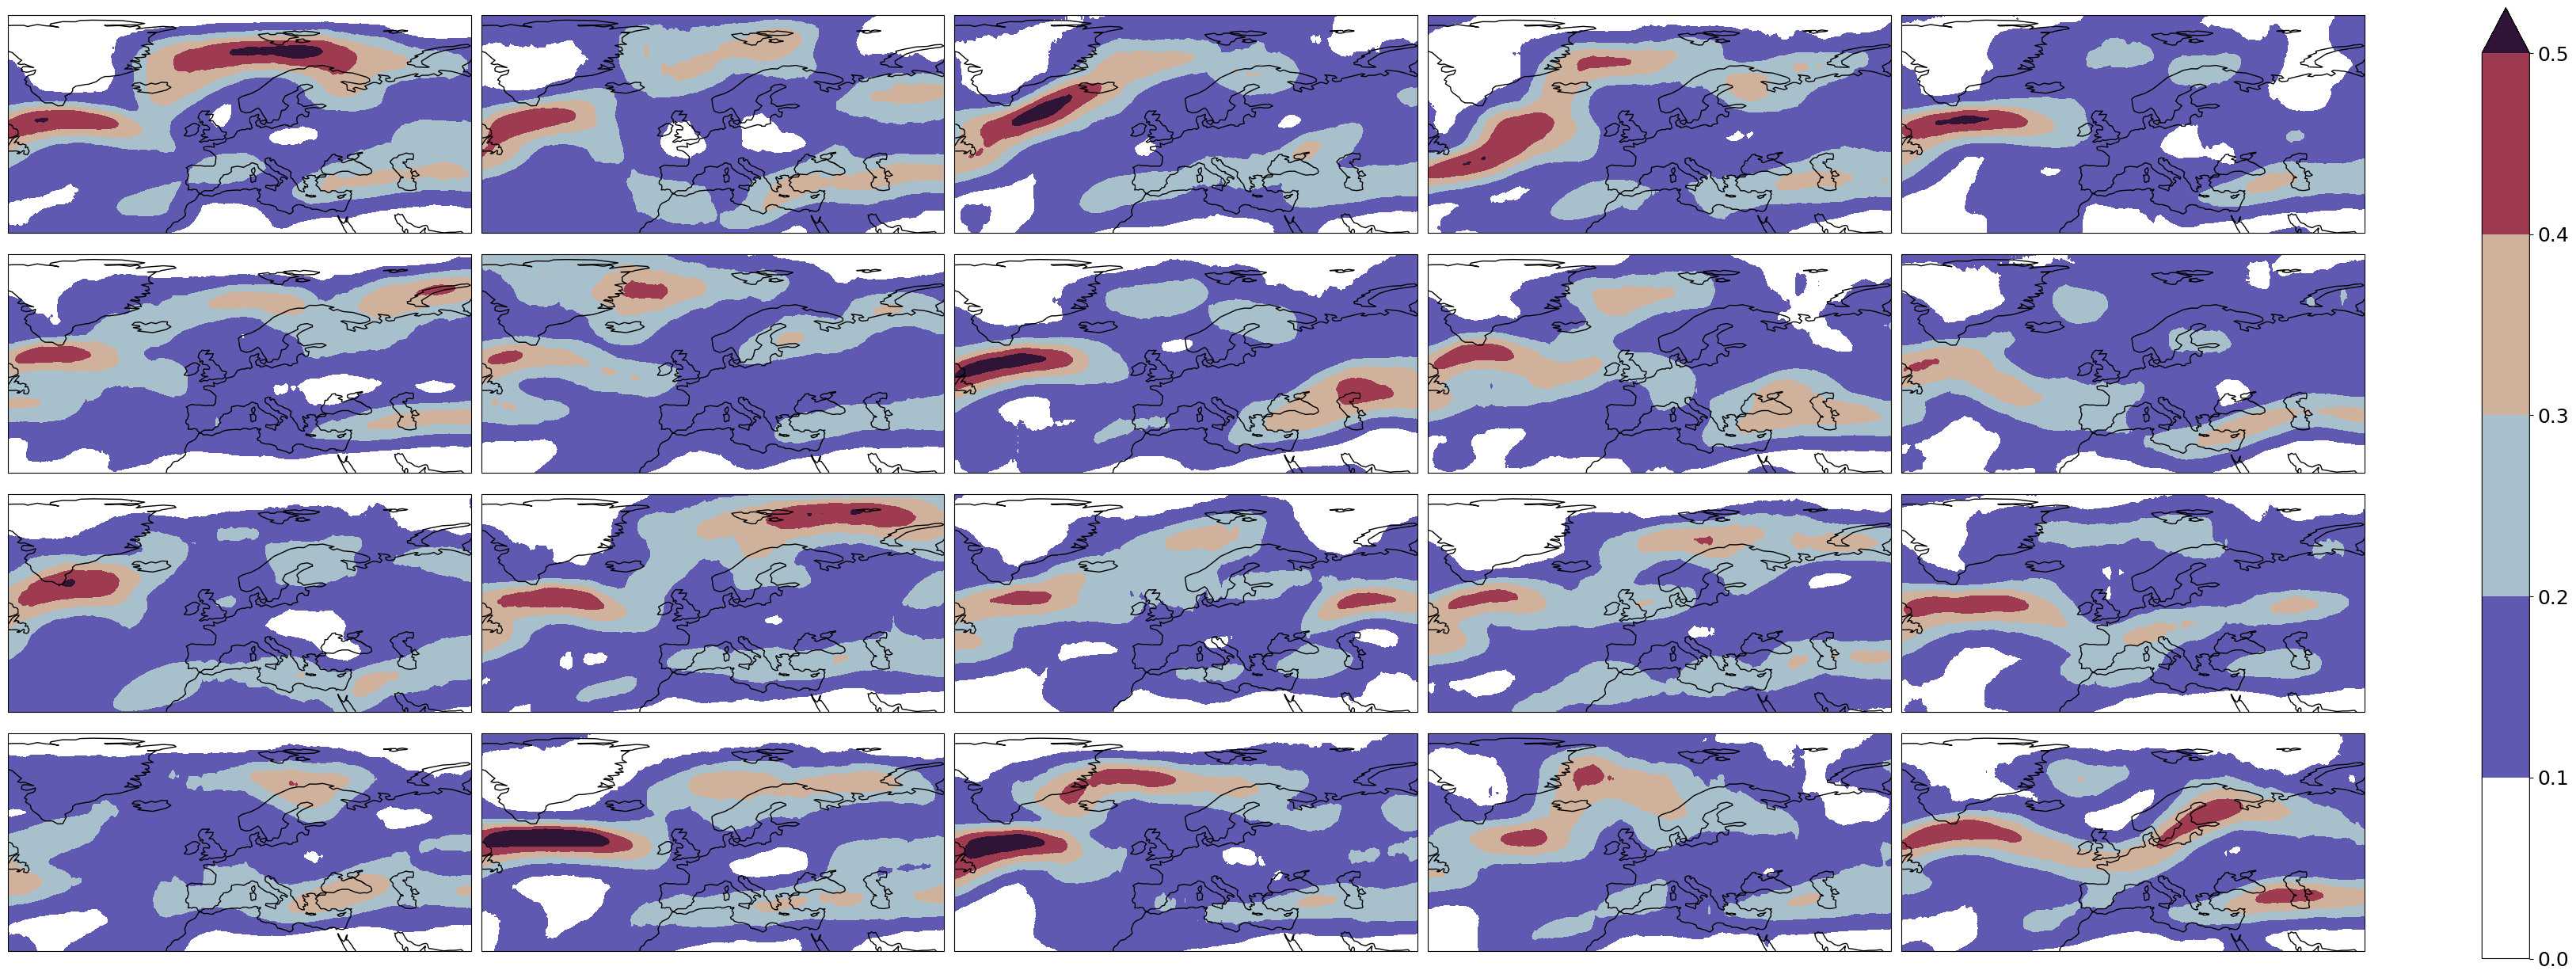

In [9]:
clu = phase_space(
    da_s_cropped[0], desom.decoder, symmetrize=False, factor=1, transparify=1
)

# KERASOM

In [5]:
X_test_size = 2500
X_train_size = X.shape[0] - X_test_size
X_flat, Xmin, Xmax = rescale(X)
X_flat = X_flat.reshape(X.shape[0], -1)
X_train_flat, X_test_flat = train_test_split(
    X_flat, train_size=X_train_size, test_size=X_test_size
)

In [ ]:
epochs = 20

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, mode="min"
)
som_callback = SOMCallback(epochs, start_sigma=3, speed=3)
plot_som_callback = PlotSOMCallback(
    da_s, Xmin, Xmax, cmap="twilight_shifted", transparify=2, nlevels=11, q=0.97
)

callbacks = [som_callback, plot_som_callback, early_stopping]

distance_weights = (
    degcos(da_s.lat) * da_s.lon.copy(data=np.ones(len(da_s.lon)))
).values
distance_weights = distance_weights.reshape(1, 1, -1)
map_size = (6, 6)
pbc = True
som_layer = SOMLayer(
    map_size, PBC=pbc, KSN=False, name="som", distance_weights=distance_weights
)
kerasom = Kerasom(som_layer)
kerasom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
batch_size = 32
kerasom.som_layer.build((batch_size, X_flat.shape[1]))


history = kerasom.fit(
    X_train_flat,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test_flat,),
    callbacks=callbacks,
    verbose=1,
)

name = f'{map_size[0]}x{map_size[1]}{"_PBC" if pbc else ""}'

In [8]:
tf.keras.saving.save_model(kerasom, f"results/models/kerasom/kerasom_6x6_PBC")

In [6]:
kerasom = tf.keras.saving.load_model(f"results/models/kerasom/kerasom_6x6_PBC")

In [25]:
X_flat, Xmin, Xmax = rescale(X)
X_flat = X_flat.reshape(X.shape[0], -1)
X_flat_red = np.random.choice(X_flat.shape[0], size=6000, replace=False)
X_flat = X_flat[X_flat_red]

In [ ]:
epochs = 50
from IPython.display import clear_output

distance_weights = (
    degcos(da_s.lat) * da_s.lon.copy(data=np.ones(len(da_s.lon)))
).values
distance_weights = distance_weights.reshape(1, 1, -1)
plot_kwargs = dict(transparify=2, nlevels=11, q=0.97)

all_results = {}
RESULTS = "/storage/homefs/hb22g102/persistent-extremes-era5/results/models"
for y, dy, pbc in product([3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3], [False, True]):
    map_size = (y + dy, y)
    print(f"{map_size=}, {pbc=}")
    som_callback = SOMCallback(epochs, start_sigma=(y + dy) / 2, speed=(y + dy) / 2)
    callbacks = [som_callback, TqdmCallback(verbose=1)]

    som_layer = SOMLayer(
        map_size, PBC=pbc, KSN=True, name="som", distance_weights=distance_weights
    )
    kerasom = Kerasom(som_layer)

    kerasom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

    batch_size = 32

    history = kerasom.fit(
        X_flat,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=callbacks,
        verbose=0,
    )
    name = f'{map_size[0]}x{map_size[1]}{"_PBC" if pbc else ""}'
    tf.keras.saving.save_model(kerasom, f"{RESULTS}/kerasom/kerasom_{name}_reduced")

    last_loss = history.history["loss"][-1]
    energies = kerasom.som_layer.compute_energies(X_flat, 0.1).numpy()
    proj = np.min(np.abs(energies), axis=0)
    all_results[name] = {"loss": last_loss, "projection": proj}
    protos = kerasom.som_layer.prototypes.numpy()
    decoded_centers = descale(protos, Xmin, Xmax).reshape(
        protos.shape[0], *da_s.shape[1:]
    )
    to_plot = [da_s[0].copy(data=decoded_center) for decoded_center in decoded_centers]
    to_plot = [tplt.where(tplt > 0, 0) for tplt in to_plot]
    clu = Clusterplot(*map_size, honeycomb=True, region=exp_s.region)
    _ = clu.add_contourf(to_plot, **plot_kwargs)
    plt.savefig(f"Figures/kerasom_training/{name}.png")
    plt.close()
    clear_output()

# Kerasom PCA

In [5]:
X_ = X.reshape(X.shape[0], -1)
pca = PCA(200).fit(X_)
X_pca = pca.transform(X_)

In [43]:
epochs = 10
from IPython.display import clear_output

distance_weights = pca.explained_variance_ratio_
distance_weights = distance_weights.reshape(1, 1, -1)
plot_kwargs = dict(transparify=2, nlevels=11, q=0.97)

all_results = {}
RESULTS = "/storage/homefs/hb22g102/persistent-extremes-era5/results/models"
for y, dy, pbc in product([4, 5, 6, 7, 8, 9], [0, 1, 2, 3], [True]):
    map_size = (y + dy, y)
    print(f"{map_size=}, {pbc=}")
    som_callback = SOMCallback(epochs, start_sigma=(y + dy) / 2, speed=3)
    callbacks = [som_callback, TqdmCallback(verbose=0)]

    som_layer = SOMLayer(
        map_size, PBC=pbc, KSN=True, name="som", distance_weights=distance_weights
    )
    kerasom = Kerasom(som_layer)

    kerasom.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-1))

    batch_size = 32

    history = kerasom.fit(
        X_pca,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=callbacks,
        verbose=0,
    )
    name = f'{map_size[0]}x{map_size[1]}{"_PBC" if pbc else ""}'
    tf.keras.saving.save_model(kerasom, f"{RESULTS}/kerasom/kerasom_{name}_pca")

    last_loss = history.history["loss"][-1]
    energies = kerasom.som_layer.compute_energies(X_pca, 0.1).numpy()
    proj = np.min(np.abs(energies), axis=0)
    all_results[name] = {"loss": last_loss, "projection": proj}
    protos = kerasom.som_layer.prototypes.numpy()
    decoded_centers = pca.inverse_transform(protos).reshape(
        protos.shape[0], *da_s.shape[1:]
    )
    to_plot = [da_s[0].copy(data=decoded_center) for decoded_center in decoded_centers]
    to_plot = [tplt.where(tplt > 0, 0) for tplt in to_plot]
    clu = Clusterplot(*map_size, honeycomb=True, region=exp_s.region)
    _ = clu.add_contourf(to_plot, **plot_kwargs)
    plt.savefig(f"Figures/kerasom_training/{name}_pca.png")
    plt.close()
    clear_output()

In [7]:
RESULTS = "/storage/homefs/hb22g102/persistent-extremes-era5/results/models"

In [13]:
results = {}
quantiles = np.arange(0, 1.05, 0.05)
for y, dy, pbc in product([4, 5, 6, 7, 8, 9], [0, 1, 2, 3], [False, True]):
    map_size = (y + dy, y)
    name = f'{map_size[0]}x{map_size[1]}{"_PBC" if pbc else ""}'
    kerasom = tf.keras.saving.load_model(f"{RESULTS}/kerasom/kerasom_{name}_pca")
    protos = kerasom.som_layer.prototypes.numpy()
    proj_pcaspace = (
        np.einsum("ik,jk->ij", X_pca, protos)
        / np.linalg.norm(X_pca, axis=1)[:, None]
        / np.linalg.norm(protos, axis=1)[None, :]
    )
    maxproj = np.max(proj_pcaspace, axis=1)
    kerasom.compute_loss(X_pca)
    loss = kerasom.loss_tracker.result().numpy()
    results[name] = [*np.quantile(maxproj, q=quantiles), loss]

In [24]:
quantiles_str = [str(int(i)).zfill(2) for i in quantiles * 100]
columns = [*[f"q{n}" for n in quantiles_str], "loss"]
df = pd.DataFrame.from_dict(results, orient="index", columns=columns).iloc[1::2]

In [27]:
df.index

Index(['4x4_PBC', '5x4_PBC', '6x4_PBC', '7x4_PBC', '5x5_PBC', '6x5_PBC',
       '7x5_PBC', '8x5_PBC', '6x6_PBC', '7x6_PBC', '8x6_PBC', '9x6_PBC',
       '7x7_PBC', '8x7_PBC', '9x7_PBC', '10x7_PBC', '8x8_PBC', '9x8_PBC',
       '10x8_PBC', '11x8_PBC', '9x9_PBC', '10x9_PBC', '11x9_PBC', '12x9_PBC'],
      dtype='object')

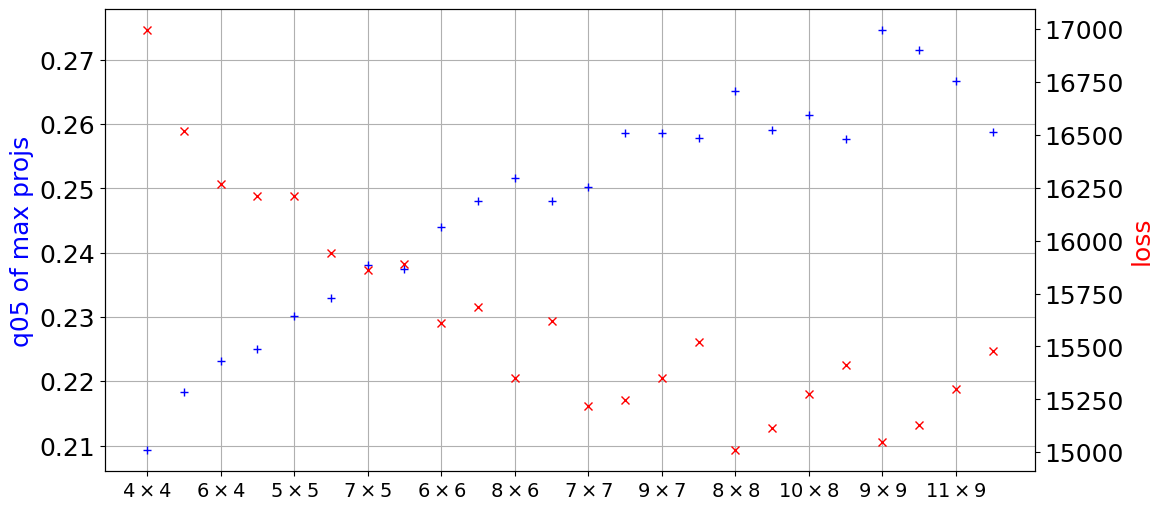

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
quantile = "q05"
ax.plot(df[quantile], "b+")
indices = np.arange(0, len(df), 2)
labels = [s.split("_")[0] for s in df.index[indices]]
labels = [s.replace("x", r"\times") for s in labels]
labels = [f"${s}$" for s in labels]
ax.set_xticks(indices, labels=labels, fontsize=14)
ax.set_ylabel(f"{quantile} of max projs", color="blue")
axx = ax.twinx()
axx.plot(df["loss"], "rx")
axx.set_ylabel("loss", color="red")
ax.grid()

In [53]:
np.einsum("ik,jk->ij", X_pca, protos) / np.linalg.norm(X_pca, axis=1)[:, None] / np.linalg.norm(protos, axis=1)[None, :]

array([[ 0.60816,  0.54074,  0.42432, ...,  0.01786,  0.25037,  0.45291],
       [ 0.58925,  0.51551,  0.37915, ..., -0.00409,  0.22135,  0.42414],
       [ 0.6138 ,  0.54139,  0.40054, ...,  0.01083,  0.23796,  0.44374],
       ...,
       [-0.1696 , -0.32825, -0.42063, ..., -0.2744 , -0.24445, -0.08075],
       [-0.1853 , -0.33479, -0.41401, ..., -0.26324, -0.24825, -0.10541],
       [-0.22158, -0.35208, -0.42021, ..., -0.23764, -0.24796, -0.1259 ]],
      dtype=float32)

In [57]:
meanX[None, :].shape

(1, 26741)

In [71]:
X__ = X_ / np.linalg.norm(X_, axis=1)[:, None]

In [72]:
meanX = np.mean(X__, axis=0)
extra = np.tensordot(meanX[None, :], X__, (1, 1)).ravel()
extra = extra[:, None] + extra[None, :] + np.linalg.norm(meanX)

In [73]:
np.dot(X__[0], X__[1])

0.9437733

In [77]:
np.dot(X_pca[0], X_pca[1]) / np.linalg.norm(X_pca[0]) / np.linalg.norm(X_pca[1]) + extra[0, 1]

0.9322899

In [65]:
extra

array([[-0.06602, -0.06538, -0.06649, ..., -0.00045,  0.00066,  0.00282],
       [-0.06538, -0.06474, -0.06585, ...,  0.00019,  0.0013 ,  0.00346],
       [-0.06649, -0.06585, -0.06696, ..., -0.00092,  0.00019,  0.00235],
       ...,
       [-0.00045,  0.00019, -0.00092, ...,  0.06512,  0.06623,  0.06839],
       [ 0.00066,  0.0013 ,  0.00019, ...,  0.06623,  0.06734,  0.0695 ],
       [ 0.00282,  0.00346,  0.00235, ...,  0.06839,  0.0695 ,  0.07165]],
      dtype=float32)

In [11]:
protos_realspace = pca.inverse_transform(protos)
nclu = protos_realspace.shape[0]
protos_realspace = protos_realspace.reshape(nclu, *da_s.shape[1:])
coords = {"cluster": np.arange(nclu), "lat": da_s.lat.values, "lon": da_s.lon.values}
protos_realspace = xr.DataArray(protos_realspace, coords=coords)

In [12]:
proj_results = []
indices = np.array_split(np.arange(len(da_s)), 100)
for indice in tqdm(indices):
    proj = (da_s[indice] * protos_realspace).sum(["lon", "lat"])
    norm1 = np.sqrt((da_s[indice] ** 2).sum(["lon", "lat"]))
    norm2 = np.sqrt((protos_realspace**2).sum(["lon", "lat"]))
    proj = proj / norm1 / norm2
    proj_results.append(proj)

100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


In [21]:
proj_realspace = xr.concat(proj_results, dim="time")

In [22]:
proj_pcaspace = proj_realspace.copy(data=proj)

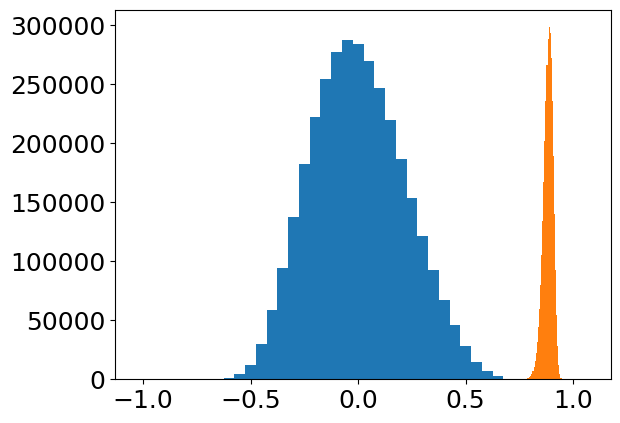

In [42]:
_ = proj_pcaspace.plot.hist(bins=np.arange(-1.025, 1.075, 0.05))
_ = proj_realspace.plot.hist(bins=np.arange(0, 1.075, 0.005))

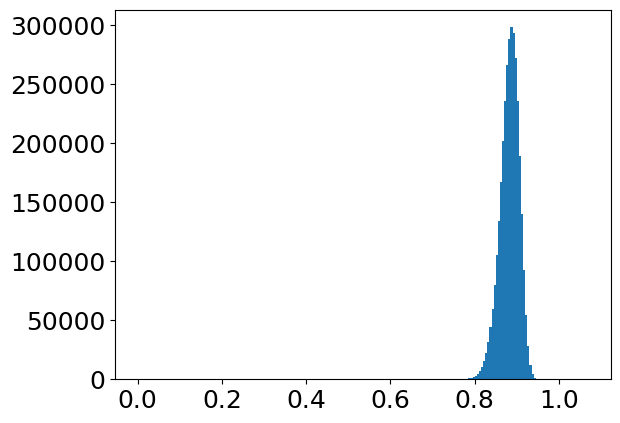

In [41]:
_ = proj_realspace.plot.hist(bins=np.arange(0, 1.075, 0.005))

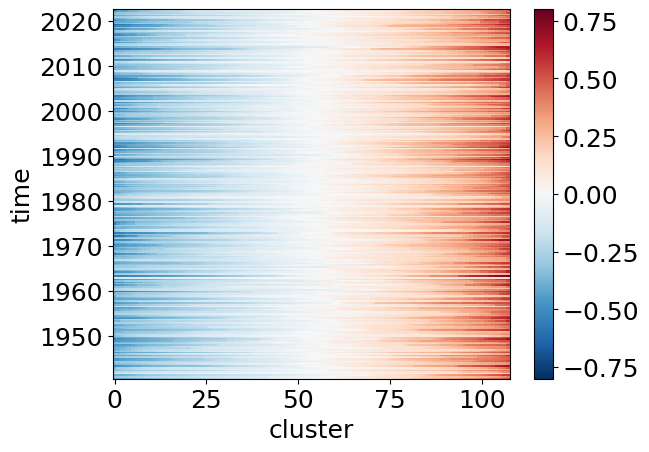

In [49]:
proj_pcaspace.copy(data=np.sort(proj_pcaspace.values, axis=1)).plot()

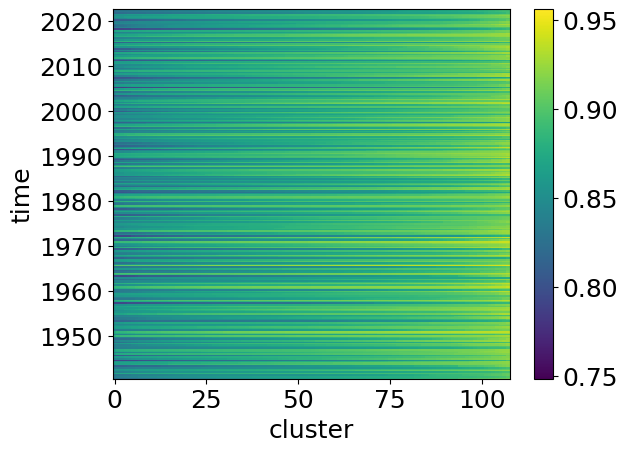

In [50]:
proj_realspace.copy(data=np.sort(proj_realspace.values, axis=1)).plot()